## BAO inverse distance ladder
I provide you with a series of power spectrum measurements, at effective redshifts $z_{\mathrm{zeff}}$ = 0.1 to 1.9.
In this session, you will:

1) measure the BAO isotropic parameter $\alpha(z_{\mathrm{eff}}) = \left[D_{V}(z_{\mathrm{eff}})/r_{\mathrm{drag}}\right] / \left[D_{V}^{\mathrm{fid}}(z_{\mathrm{eff}})/r_{\mathrm{drag}}^{\mathrm{fid}}\right]$ of each of the measurements

2) with these measurements, you will constrain $\Omega_{m}, \Omega_{k}$ (hence detect dark energy!)

3) provided a value of $r_{\mathrm{drag}}$ (in $\mathrm{Mpc}$), you will perform an "inverse distance ladder" analysis: fit all the $\alpha(z_{\mathrm{eff}})$ by varying $H_{0}$ and $\Omega_{m}$

4) those finding the correct $\Omega_{m}$, $\Omega_{k}$ and $H_{0}$ (I know the truth, you don't!) win!

5) do you remember how to compute the correlation function? (last year's TD) What about the power spectrum? If any question, please ask!

### First, look at power spectrum measurements

At effective redshift 0.10 first k are [0.007493 0.016066], pk0 [43579.87204033 59574.23898799]
At effective redshift 0.30 first k are [0.007493 0.016066], pk0 [58159.9772374  64155.31692157]
At effective redshift 0.50 first k are [0.007493 0.016066], pk0 [28531.12726767 56291.46363898]
At effective redshift 0.70 first k are [0.007493 0.016066], pk0 [36963.90375436 63273.70445805]
At effective redshift 0.90 first k are [0.007493 0.016066], pk0 [50049.25596832 61289.87142888]
At effective redshift 1.10 first k are [0.007493 0.016066], pk0 [48863.32973323 53625.9455684 ]
At effective redshift 1.30 first k are [0.007493 0.016066], pk0 [34614.37361749 54242.10958604]
At effective redshift 1.50 first k are [0.007493 0.016066], pk0 [56665.8185425  64685.36388254]
At effective redshift 1.70 first k are [0.007493 0.016066], pk0 [46548.2941793 54362.160772 ]
At effective redshift 1.90 first k are [0.007493 0.016066], pk0 [41706.41774374 50776.07570434]


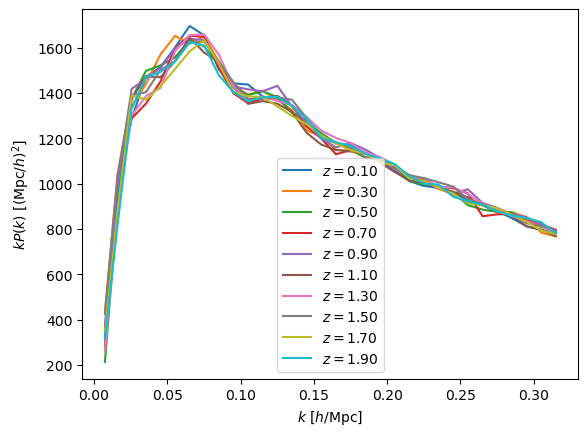

Attributes: {'space': 'power', 'tracer': 'LRGpCMASS', 'zeff': 1.9000000000000001, 'recon': False, 'ells': [0, 2, 4]}


In [1]:
import numpy as np
from matplotlib import pyplot as plt

from environment import Measurement, list_path_sim_measurement # contains paths

list_path = list_path_sim_measurement()
list_data = []

for path in list_path:
    m = Measurement.load(path)
    print('At effective redshift {:.2f} first k are {}, pk0 {}'.format(m.attrs['zeff'],m.x[:2],m.y[0,:2]))
    plt.plot(m.x,m.x*m.y[0],label='$z = {:.2f}$'.format(m.attrs['zeff']))
    list_data.append(m)

plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.legend()
plt.show()
# m is an instance of Measurement
# k (wavenumber) array is m.x
# pk (power spectrum) is m.y
# m.y is of shape (1,len(m.x)): the first Legendre multipole (monopole).
print('Attributes: {}'.format(m.attrs))

### Code isotropic BAO power spectrum model

The idea is to measure *only* the position of the BAO, marginalizing over the shape of the power spectrum, to remain robust to distortions due to observational systematics.
For this we decompose the fiducial power spectrum into *wiggle* and *no-wiggle* parts. We will allow the *wiggle* part to move, keeping the *no-wiggle* part fixed, adding polynomial in $k$ to adjust the shape of the data power spectrum.

In [2]:
# first get a linear power spectrum in $(\mathrm{Mpc}/h)^{3}$, at the redshifts of interest
# use e.g. classy, camb... (also cosmoprimo, personal package: https://github.com/adematti/cosmoprimo)
# fiducial cosmological parameters (used to the power spectrum above) is:
# dict(Omega_m=0.31,Omega_b=0.022/0.676**2,h=0.676,sigma8=0.8,n_s=0.97)

In [3]:
# Then you need a smooth power spectrum, matching the linear power spectrum but without BAO wiggles.
# Several options:
# 1) use Eisenstein & Hu 1998 formula, complemented with polynomials to correctly adjust the linear power spectrum
# 2) fit the linear power spectrum in log/log with a polynomial of degree 13 (Hinton2017)
# 3) use cosmoprimo PowerSpectrumBAOFilter(pk_interpolator, engine='wallish2018')

In [4]:
# Plot wiggles = linear power spectrum / no-wiggle power spectrum

Model equation is: $P(k,\alpha) = B^{2} [P_{\mathrm{nw}}(k) + \sum_{i=0}^{2} A_{i} k^{i}] \lbrace 1 + [\mathcal{O}(k/\alpha) - 1] e^{- \frac{1}{2} \Sigma_{\mathrm{nl}}^{2}k^{2}} \rbrace$  
$P_{\mathrm{nw}}$ is the no-wiggle power spectrum.  
$\mathcal{O}(k) = P_{\mathrm{lin}}(k)/P_{\mathrm{nw}}(k)$ are the wiggles.  
Free parameters are: $\alpha, B, A_{i}$, parameter of cosmological interest in $\alpha$.  
Choose for the non-linear damping of BAO wiggles $\Sigma_{\mathrm{nl}} = 6.7\;\mathrm{Mpc/h}$.

In [5]:
sigmanl = 6.7
def pk_iso(k, alpha, B, A0, A1, A2, A3=0):
    """Code here power spectrum model"""

### Now model fitting
Repeat, for each redshift z:  
Build $\chi^{2} = (\mathrm{data} - \mathrm{model})^T C^{-1} (\mathrm{data} - \mathrm{model})$  
For a rapid check, minimize chi2 for example with scipy.optimize.minimize

In [6]:
from scipy import optimize

nbb = 3
# for alpha, B, broadbands
init = [1.,3.] + [0.]*nbb
bounds = [(0.88,1.12),(1.,5.)] + [(-5e4,5e4)]*nbb

for m in list_data:
    covariance = m.cov
    invcovariance = np.linalg.inv(covariance)
    k = m.x
    data = m.y[0]
    
    def chi2(args):
        """Write chi2"""
    
    #result = optimize.minimize(chi2,init,method='SLSQP',bounds=bounds)
    #args = result.x
    #minchi2 = chi2(args)
    #msg = 'Reduced chi2 is {:.4f}/({:d} - {:d}) = {:.4f}'.format(minchi2,len(k),len(args),minchi2/(len(k) - len(args)))
    #print(msg)
    """Make plot of data, model, error bars"""

We want an error on our alpha measurement. Either:
- likelihood profiling: repeat the above for alpha values in e.g. [0.9,1.1], and take errors at $\chi_{\mathrm{min}}^{2} + 1$
- likelihood sampling: use sampler, e.g. https://github.com/minaskar/zeus

In [7]:
#import emcee
#import corner

nsteps = 4000
ndim = len(bounds)
nwalkers = 2*ndim
list_mean = []
list_covariance = []

for m in list_data:

    covariance = m.cov[:len(m.x),:len(m.x)]
    invcovariance = np.linalg.inv(covariance)
    k = m.x
    data = m.y[0]
    
    def chi2(args):
        """Write chi2"""
    
    def logprior(args):
        """Write flat prior between bounds"""
    
    # Write posterior here (take flat priors between bounds on all parameters)
    def logposterior(args):
        """Write log-posterior"""
    
    #sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior)
    #start = [[np.random.normal(v,(b[1]-b[0])/10.) for v,b in zip(init,bounds)] for i in range(nwalkers)]
    #sampler.run_mcmc(start,nsteps)
    #samples = sampler.get_chain(flat=True)
    # Look at samples, remove burnin
    # Take mean (or median) and covariance of samples
    #list_mean.append(mean)
    #list_covariance.append(covariance)
    #labels = ['alpha','B'] + ['A{:d}'.format(i) for i in range(nbb)]
    #fig = corner.corner(samples,labels=labels,quantiles=[0.16,0.5,0.84],show_titles=True,title_kwargs={'fontsize':14})
    #plt.show()
    #plt.close(fig)

### Expansion history
$\alpha_{\mathrm{theory}}(z) = \left[D_{V}(z_{\mathrm{eff}})/r_{\mathrm{drag}}\right] / \left[D_{V}^{\mathrm{fid}}(z_{\mathrm{eff}})/r_{\mathrm{drag}}^{\mathrm{fid}}\right]$  
$D_{V}(z) = z_{\mathrm{eff}}^{1/3} D_{M}(z)^{2/3} D_{H}(z)^{1/3}$ with $D_{M}(z)$ comoving transverse distance, $D_{H}(z) = c/H(z)$ "Hubble distance"  
Code up $D_{M}(z)$, $D_{H}(z)$ as a function of $\Omega_{m}$ and $\Omega_{k}$ (faster than creating a new cosmology at each MCMC step).  
Build the $\chi^{2}$ of the previously measured $\alpha$, using $\alpha_{\mathrm{theory}}$ as a model.
Previously measured $\alpha$ `list_data` should be considered independent (no cross-correlations between them; hence the covariance matrix is diagonal, with `list_covariance` as diagonal elements.
This $\chi^{2}$ depends on $r_{\mathrm{drag}}$ (in $\mathrm{Mpc}/h$), $\Omega_{m}$ and $\Omega_{k}$ if free curvature (entering $D_{M}$ and $D_{H}$).  
Use very wide prior on $r_{\mathrm{drag}}$ as we don't want to make any assumption about primordial universe,
rather constrain expansion history.

In [8]:
list_z,list_data_dv = [],[]
for data,m,c in zip(list_data,list_mean,list_covariance):
    z = data.attrs['zeff']
    # everything in Mpc/h
    # turn measured alpha m into DV(zeff)/rdrag (same for covariance c)
    list_z.append(z)

list_z = np.array(list_z)

# define Hubble parameter, comoving angular distance, spherically-averaged distance DV
# model is DV/rdrag at each data z.

In [9]:
def chi2(args):
    """Write chi2, assume independent measurements at each redshift."""

# For rdrag (Mpc/h), Omega_m, Omega_k
init = [100.,0.3,0.]
bounds = [(20,400),(0.01,0.9),(-0.8,0.8)]

def logprior(args):
    """Write flat prior between bounds"""

def logposterior(args):
    """Write log-posterior"""

#ndim = len(init)
#nwalkers = 4*ndim
#nsteps = 3000
#sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior)
#start = [[np.random.normal(v,(b[1]-b[0])/10.) for v,b in zip(init,bounds)] for i in range(nwalkers)]
#sampler.run_mcmc(start,nsteps)
#samples = sampler.get_chain(flat=True)
# Remove burnin and plot

### Inverse distance ladder
Do the same 
For $r_{\mathrm{drag}}$ use a Gaussian prior $r_{\mathrm{drag}} = 149.47 \pm 0.48 \; \mathrm{Mpc}$.  
Assume zero curvature for this exercise (though you can let it free in general, in addition to different dark energy models --- all those are constrained by BAO).
Sample the likelihood and draw the contours $\Omega_{m} - H_{0}$.

In [10]:
def chi2(args):
    """Write chi2, assume independent measurements at each redshift."""

# For rdrag (Mpc), H0, Omega_m
init = [149.47,70,0.3]
bounds = [(100,200),(50,100),(0.1,0.5)]

def logprior(args):
    """Write flat prior between bounds + Gaussian prior on rdrag"""

def logposterior(args):
    """Write log-posterior"""

#ndim = len(init)
#nwalkers = 4*ndim
#nsteps = 3000
#sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior)
#start = [[np.random.normal(v,(b[1]-b[0])/10.) for v,b in zip(init,bounds)] for i in range(nwalkers)]
#sampler.run_mcmc(start,nsteps)
#samples = sampler.get_chain(flat=True)
# Remove burnin and plot

### Let us be a bit more closer to practice
Actually, in practice we do not have a measurement of $r_{\mathrm{drag}}$.  
Rather, measurements of deuterium abundance, together with BBN, constrain $\omega_{b} = \Omega_{b} h^{2}$.  
Implement $r_{\mathrm{drag}}$, following https://arxiv.org/abs/astro-ph/9709112, eq. 4 - 6.
For $z_{\mathrm{drag}}$, rather use https://arxiv.org/abs/astro-ph/9510117, eq. E1 (found better match to Boltzmann code).
Fix $T_\mathrm{cmb} = 2.7255$ (Cobe-FIRAS).  
Redo the previous sampling, varying $H_{0}$, $\Omega_{m}$ and $\omega_{b}$ with a prior: $\omega_{b} = 0.02235 \pm 0.00037$.

In [11]:
def rs_drag(omega_b, omega_m):
    """Write approximation for rs_drag as a function of omega_b, omega_m"""

In [12]:
# For omega_b, H0, Omega_m
init = [0.02235,70,0.3]
bounds = [(0.01,0.03),(50,100),(0.1,0.5)]

def logprior(args):
    """Write flat prior between bounds + Gaussian prior on omega_b"""

def logposterior(args):
    """Write log-posterior"""

#ndim = len(init)
#nwalkers = 4*ndim
#nsteps = 3000
#sampler = emcee.EnsembleSampler(nwalkers,ndim,logposterior)
#start = [[np.random.normal(v,(b[1]-b[0])/10.) for v,b in zip(init,bounds)] for i in range(nwalkers)]
#sampler.run_mcmc(start,nsteps)
#samples = sampler.get_chain(flat=True)
# Remove burnin and plot

### Bonus, work with real data!
Follow instructions in eBOSS_LRGpCMASS.ipynb